##PROBLEM:
#This data was collected from conducting preliminary analysis on a 128-bit encryption algorithm implementation on an FPGA board (Sakura G). These files correspond to 10,000 executions with random input and a fixed secret key.

##So...
#The challenge is to break an AES 128 encryption via a side channel attack, aka using an analysis of power consumption data collected as an input file was encrypted to an output file to determine the secret key that was used to do so.

##If you want to run the notebook, you can download the required files here, you'll need all 3.
https://drive.google.com/drive/folders/1WpezoQtQeHSOn32otSH_YLF-U06r5fXC?usp=sharing

##Dependencies:

In [3]:
!pip install numpy matplotlib pycryptodome tqdm # Keep these dependencies

##Setting Up S-Box
* The box is a way to apply a non linear transformation to a byte of information
* It is one of the ways that AES encrypts its data and why it is secure, without a transformation like this it would be much easier to crack.
*  Changing a single bit in the input to the S-Box typically results in about half the bits changing in its output, in an unpredictable manner. This obscures the relationship between the key and the ciphertext.

* We also define the Hamming Weight model, which is simply the number of 1's in a value. This matters because in computing, the more 1's that are being represented for a value, the more transistors that are being powered at the moment. For this reason it is reffered to as a leakage model.


The S-Box operates on data byte-by-byte. When an intermediate value (which depends on a known plaintext byte and a guessed key byte) is processed by or results from the S-Box operation, it's hypothesized to cause variations in the device's power consumption. If we can model this power variation (e.g., using the Hamming Weight of the intermediate value), we can test guesses for each key byte. The correct key byte guess will produce a sequence of hypothetical power consumptions (across many different plaintext values) that strongly correlates with the actual measured power traces. This byte-by-byte attack significantly reduces the complexity of finding the secret key.

In [4]:
import numpy as np
from tqdm.notebook import trange # Progress bar
import time

# AES S-Box (standard for AES-128/192/256)
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

# Helper function to convert hex string to byte array
def hex_to_bytes(hex_string):
    return bytes.fromhex(hex_string)

# Helper function for Hamming Weight (leakage model)
def hw(n):
    return bin(n).count('1')



Loads our data into memory and checks the shape to make sure they are correct. Simple.

In [5]:
# Load power traces
print("Loading traces...")
traces = np.loadtxt("traces.csv", delimiter=',')
print(f"Traces loaded. Shape: {traces.shape}") # Should be (num_traces, num_samples_per_trace)

# Load plaintexts
plaintexts = []
print("Loading plaintexts...")
with open("input_plaintext.txt", "r") as f:
    for line in f:
        plaintexts.append(hex_to_bytes(line.strip()))

# Convert plaintexts to a NumPy array of integers (bytes)
# Ensure all plaintexts are the same length (e.g., 16 bytes for AES-128)
if not all(len(p) == 16 for p in plaintexts):
     print("Warning: Not all plaintexts are 16 bytes long!")
plaintexts_np = np.array([list(p) for p in plaintexts], dtype=np.uint8)
print(f"Plaintexts loaded. Shape: {plaintexts_np.shape}") # Should be (num_traces, 16)

# Basic check: Number of traces should match number of plaintexts
num_traces = traces.shape[0]
if num_traces != plaintexts_np.shape[0]:
    raise ValueError(f"Mismatch! Number of traces ({num_traces}) != number of plaintexts ({plaintexts_np.shape[0]})")

print(f"Successfully loaded {num_traces} traces and plaintexts.")

Loading traces...
Traces loaded. Shape: (10000, 400)
Loading plaintexts...
Plaintexts loaded. Shape: (10000, 16)
Successfully loaded 10000 traces and plaintexts.


Defining some helper functions for our leakage model.

In [6]:
def calculate_intermediate(plaintext_byte, key_guess):
    """Calculates the S-Box output for a given plaintext byte and key guess."""
    return sbox[plaintext_byte ^ key_guess]

def calculate_leakage(intermediate_value):
    """Applies the leakage model (Hamming Weight)."""
    return hw(intermediate_value)


def calculate_leakage_sbox_input_hw(plaintext_byte, key_guess):
   """Applies the Hamming Weight leakage model to the S-Box INPUT."""
   sbox_input = plaintext_byte ^ key_guess
   return hw(sbox_input)

# def hd(a, b):
#   """Calculates Hamming Distance between two numbers."""
#   return bin(a ^ b).count('1')

# def calculate_leakage_hd_sbox_in_out(plaintext_byte, key_guess):
#    """Applies the Hamming Distance leakage model (SBox input vs output)."""
#    sbox_input = plaintext_byte ^ key_guess
#    # Handle potential case where input is not used if key guess makes it constant?
#    # Usually okay, as plaintext varies.
#    try:
#        sbox_output = sbox[sbox_input]
#        return hd(sbox_input, sbox_output)
#    except IndexError:
#        # This shouldn't happen with valid byte inputs/outputs, but as a safeguard
#        print(f"Warning: Index out of bounds for S-box with input {sbox_input}")
#        return 0 # Or handle appropriately

##CPA Attack Start
* Start with a key of all 0s
* Outer loop for attacking eack key byte. Stores the maximum absolute correlation across all samples, for each of the possible guesses of the current byte.
* Inner loop iterates through the power traces for these bytes and their sorresponding plaintext values. Ten calculates the hypothetical leakage using the Hamming Weight of the S-Box output. Formats these values into an array called hypothetical_leakage, each value representing the predicted power consumption for the current guess.
* Calculates the Pearson Correlation Coefficients via way of the hypothetical_leakage array. This is used to find the maximum absolute correlation value across the 400 time samples we have for the current guess. (Last part of the inner loop).  
* On the outer loop, stores all of these coefficients with their corresponding byte guesses. From there we can see which of all those bytes had the highest correlation of them all .
* Prints the fully recovered key guess.


In [7]:
# --- CPA Attack ---
recovered_key = [0] * 16 # Initialize recovered key array
all_max_corrs = np.zeros((16, 256)) # Store max correlation for each guess/byte

attack_start_time = time.time()

print("Starting CPA attack...")

# Loop through each of the 16 key bytes
for byte_num in trange(16, desc="Attacking Key Byte"):
    max_corr_coeffs = np.zeros(256) # Store max correlation for each guess for the current byte

    # Loop through all possible values for this key byte (0-255)
    for k_guess in range(256):
        hypothetical_leakage = np.zeros(num_traces) # Create the array for this k_guess

        # Calculate hypothetical leakage for all traces for this key guess
        for i in range(num_traces):
            plaintext_byte = plaintexts_np[i, byte_num]
            intermediate = calculate_intermediate(plaintext_byte, k_guess)
            hypothetical_leakage[i] = calculate_leakage(intermediate) # Using SBox OUTPUT HW

        # Ensure leakage vector is not constant (avoid division by zero in correlation)
        if np.std(hypothetical_leakage) == 0:
            max_corr_coeffs[k_guess] = -1 # Assign low correlation if leakage is constant
            continue

        # Calculate correlation between leakage and each trace sample point
        corrs = np.zeros(traces.shape[1])
        leakage_mean = np.mean(hypothetical_leakage) # Pre-calculate mean for efficiency
        leakage_std_dev = np.std(hypothetical_leakage) # Pre-calculate std dev

        # Pre-calculate trace column means and std devs for efficiency
        trace_col_means = np.mean(traces, axis=0)
        trace_col_std_devs = np.std(traces, axis=0)

        # Vectorized correlation calculation (more efficient)
        # Ensure shapes are compatible: (num_traces,) vs (num_traces, num_samples)
        leakage_centered = hypothetical_leakage - leakage_mean
        traces_centered = traces - trace_col_means # Broadcasting handles this

        numerator = np.dot(leakage_centered, traces_centered) # Dot product for sum of products

        denominator = num_traces * leakage_std_dev * trace_col_std_devs

        # Handle division by zero for constant trace columns
        corrs = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)


        # Find the maximum absolute correlation across all sample points for this key guess
        max_corr_coeffs[k_guess] = np.max(np.abs(corrs))

    # Store the correlations for this byte for later analysis/plotting
    all_max_corrs[byte_num, :] = max_corr_coeffs

    # Find the key guess with the highest correlation for this byte
    best_guess = np.argmax(max_corr_coeffs)
    recovered_key[byte_num] = best_guess
    # print(f"Byte {byte_num}: Best guess = {best_guess:02x} (Max Correlation: {max_corr_coeffs[best_guess]:.4f})\") # Optional print


attack_end_time = time.time()
print(f"\nAttack finished in {attack_end_time - attack_start_time:.2f} seconds.")

# Print the full recovered key
recovered_key_hex = bytes(recovered_key).hex()
print(f"\nRecovered Key Guess: {recovered_key_hex}")

Starting CPA attack...


Attacking Key Byte:   0%|          | 0/16 [00:00<?, ?it/s]


Attack finished in 289.57 seconds.

Recovered Key Guess: b5182db794ed614a20719e25b8fd237b


##Visualization of the results of the CPA attack
* The first is a graph is 16 different lines, one for each secter key byte.
* This is the first clue that something may be awry.
$$$$
* The second graph is the same as above but for just the first byte of the secret key.
* We can see that the graph does not have sparsity like we would expect and want. The large amount of noise on the graph indicates that this attack was likely unsuccessful.

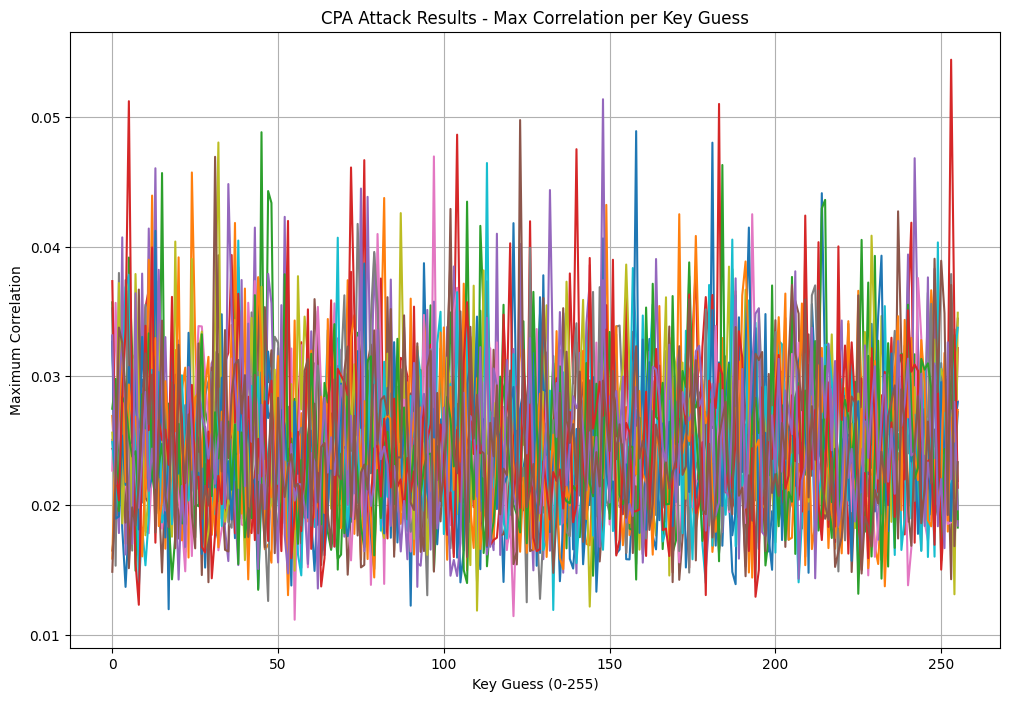

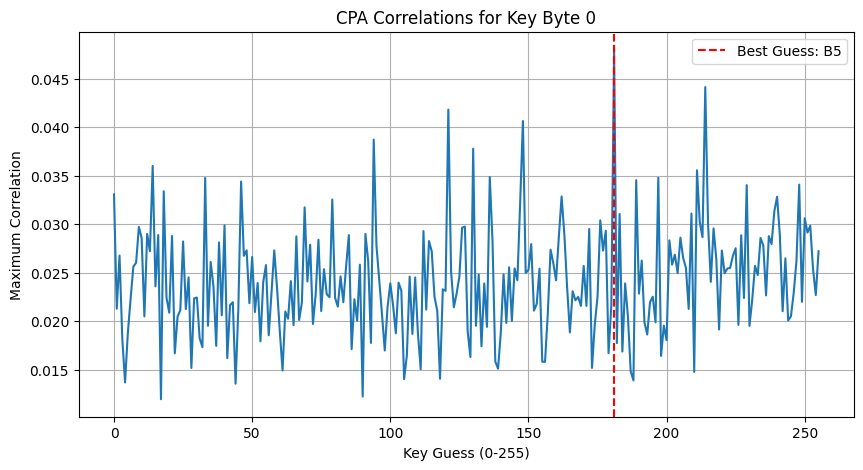

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for byte_num in range(16):
    plt.plot(all_max_corrs[byte_num, :], label=f'Byte {byte_num}')

plt.xlabel("Key Guess (0-255)")
plt.ylabel("Maximum Correlation")
plt.title("CPA Attack Results - Max Correlation per Key Guess")
plt.grid(True)
# Optional: Shrink legend if too crowded
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# You can also plot for a single byte to see the peak clearly
target_byte = 0 # Example: plot for the first byte
plt.figure(figsize=(10, 5))
plt.plot(range(256), all_max_corrs[target_byte, :])
plt.xlabel("Key Guess (0-255)")
plt.ylabel("Maximum Correlation")
plt.title(f"CPA Correlations for Key Byte {target_byte}")
plt.grid(True)
best_g = np.argmax(all_max_corrs[target_byte, :])
plt.axvline(best_g, color='r', linestyle='--', label=f'Best Guess: {best_g:02X}')
plt.legend()
plt.show()

##Checking Our Answer
* We use an AES python module to check our answer
* we can do this by trying to encrypt our given input file into our given output file.
$$$$
* It doesn't match. :(

In [9]:
from Crypto.Cipher import AES

try:
    # Load the first known ciphertext if you haven't already
    with open("output_ciphertext.txt", "r") as f:
         first_known_ciphertext_hex = f.readline().strip()
         first_known_ciphertext = hex_to_bytes(first_known_ciphertext_hex)

    # Get the first plaintext
    first_plaintext = bytes(plaintexts_np[0])

    # Create AES cipher object
    cipher = AES.new(bytes(recovered_key), AES.MODE_ECB) # Assuming ECB mode as is common in basic examples

    # Encrypt the first plaintext
    encrypted_pt = cipher.encrypt(first_plaintext)

    print("\n--- Verification ---")
    print(f"First Plaintext:      {first_plaintext.hex()}")
    print(f"Recovered Key:        {bytes(recovered_key).hex()}")
    print(f"Ciphertext (using recovered key): {encrypted_pt.hex()}")
    print(f"Known Ciphertext (from file):   {first_known_ciphertext.hex()}")

    if encrypted_pt == first_known_ciphertext:
        print("\nSUCCESS! Recovered key correctly encrypts the first plaintext.")
    else:
        print("\nFAILURE! Recovered key does not seem correct (or encryption mode differs).")

except ImportError:
    print("\nSkipping verification, PyCryptodome not installed.")
except FileNotFoundError:
     print("\nSkipping verification, output_ciphertext.txt not found.")
except Exception as e:
     print(f"\nVerification failed with error: {e}")


--- Verification ---
First Plaintext:      b9d1c48e348fe771fa464a77a178fb07
Recovered Key:        b5182db794ed614a20719e25b8fd237b
Ciphertext (using recovered key): b9bc1db95f49ecb05677b962f143ee20
Known Ciphertext (from file):   95f8847369a8573d76af987ab30a5de2

FAILURE! Recovered key does not seem correct (or encryption mode differs).


Many teams got stuck here thinking that the first byte was B5 or D6 being the second most likely. It was easy to get stuck here becasue the question does tell you to bruteforce some of the bytes. However bruteforcing the top 3 bytes can take over 10 minutes and the top 4 is like 5 hours. (I tried that too when I still thought it was the correct approach). When I realized that that wasn't it I assumed I had coded incorrectly when actually there is another step to be had here.   

##Something New
* In an attempt to discover somethong new about the data, I plotted all the correlation values of B5 and D6, which now returns the Hamming Weight leakage model to the S-Box INPUT.


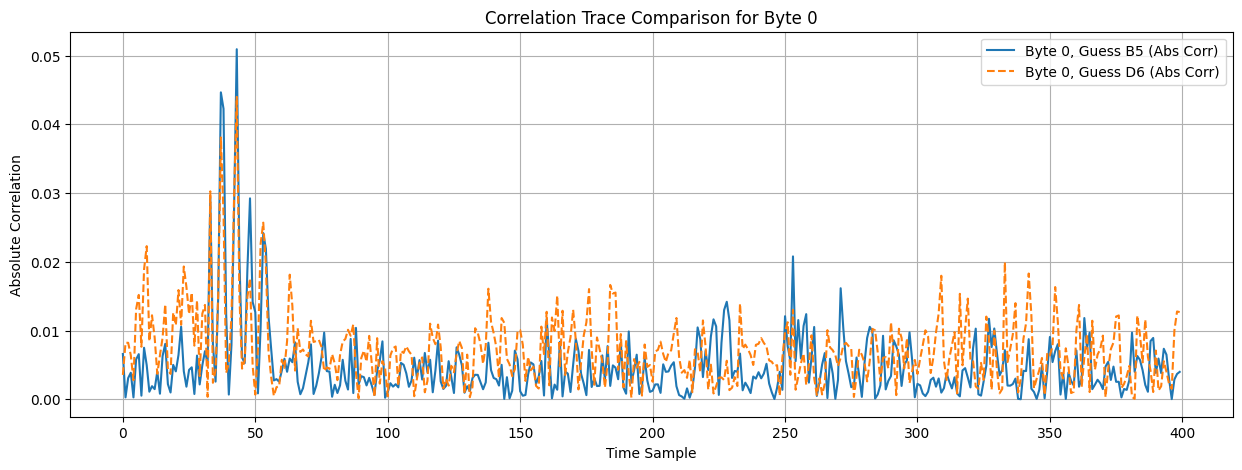

Max abs correlation for guess B5 occurred at sample index: 43 (Value: 0.0509)
Max abs correlation for guess D6 occurred at sample index: 43 (Value: 0.0440)


In [29]:
# --- Recalculate Correlation Trace for Specific Guesses ---
target_byte = 0
guess1 = 0xB5 # The best guess from previous runs
guess2 = 0xD6 # The second best guess

hypothetical_leakage1 = np.zeros(num_traces)
hypothetical_leakage2 = np.zeros(num_traces)

# Choose HW leakage model
for i in range(num_traces):
    plaintext_byte = plaintexts_np[i, target_byte]
    hypothetical_leakage1[i] = calculate_leakage_sbox_input_hw(plaintext_byte, guess1)
    hypothetical_leakage2[i] = calculate_leakage_sbox_input_hw(plaintext_byte, guess2)

# Calculate full correlation traces
corrs1 = np.zeros(traces.shape[1])
corrs2 = np.zeros(traces.shape[1])

leakage_mean1 = np.mean(hypothetical_leakage1)
leakage_std1 = np.std(hypothetical_leakage1)
leakage_mean2 = np.mean(hypothetical_leakage2)
leakage_std2 = np.std(hypothetical_leakage2)

if leakage_std1 == 0 or leakage_std2 == 0:
    print("Warning: Constant leakage for one of the guesses, skipping plot.")
else:
    for sample_point in range(traces.shape[1]):
        trace_col = traces[:, sample_point]
        trace_col_mean = np.mean(trace_col)
        trace_col_std = np.std(trace_col)

        if trace_col_std == 0:
            corrs1[sample_point] = 0
            corrs2[sample_point] = 0
        else:
            # Correlation for guess 1
            numerator1 = np.sum((hypothetical_leakage1 - leakage_mean1) * (trace_col - trace_col_mean))
            denominator1 = (num_traces * leakage_std1 * trace_col_std) # Use N in denominator for population std dev used by np.std implicitly
            if denominator1 == 0: corrs1[sample_point] = 0
            else: corrs1[sample_point] = numerator1 / denominator1

            # Correlation for guess 2
            numerator2 = np.sum((hypothetical_leakage2 - leakage_mean2) * (trace_col - trace_col_mean))
            denominator2 = (num_traces * leakage_std2 * trace_col_std)
            if denominator2 == 0: corrs2[sample_point] = 0
            else: corrs2[sample_point] = numerator2 / denominator2


    # Plot the correlation traces
    plt.figure(figsize=(15, 5))
    plt.plot(np.abs(corrs1), label=f'Byte {target_byte}, Guess {guess1:02X} (Abs Corr)')
    plt.plot(np.abs(corrs2), label=f'Byte {target_byte}, Guess {guess2:02X} (Abs Corr)', linestyle='--')
    plt.xlabel("Time Sample")
    plt.ylabel("Absolute Correlation")
    plt.title(f"Correlation Trace Comparison for Byte {target_byte}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find max correlation point for the best guess (B5) just to see where it occurred
    max_corr_point = np.argmax(np.abs(corrs1))
    print(f"Max abs correlation for guess {guess1:02X} occurred at sample index: {max_corr_point} (Value: {np.abs(corrs1[max_corr_point]):.4f})")
    max_corr_point_g2 = np.argmax(np.abs(corrs2))
    print(f"Max abs correlation for guess {guess2:02X} occurred at sample index: {max_corr_point_g2} (Value: {np.abs(corrs2[max_corr_point_g2]):.4f})")

##Looking for more validation in this avenue
* Here we check the same as the above for the most likely answers we got earlier, they also show similar results which encourage us to definetly forcus on this time sample.

In [24]:
def plot_correlation_traces_for_key(guessed_full_key_hex):
  #guessed_full_key_hex = "b5182db794ed614a20719e25b8fd237b"
  guessed_full_key_bytes_list = list(bytes.fromhex(guessed_full_key_hex)) # As list of ints

  print(f"Plotting full correlation traces for each byte of the GUESSED key: {guessed_full_key_hex}")
  print(f"Using Leakage Model: HW(SboxIn)\n") # Specify the model being used for these traces

  plt.figure(figsize=(18, 7)) # Make the figure wider
  colors = plt.cm.get_cmap('tab20').resampled(16) # Get a colormap with 16 distinct colors

  all_byte_max_corr_info_guessed_key = [] # To store (byte_num, guessed_key_byte, max_corr_sample, max_corr_value)

  # Loop through each of the 16 key bytes
  for byte_num in range(16):
      current_key_byte_guess = guessed_full_key_bytes_list[byte_num]

      hypothetical_leakage_for_guess = np.zeros(num_traces)

      # Calculate hypothetical leakage using HW(SboxIn) for the current guessed key byte
      for i in range(num_traces):
          plaintext_byte = plaintexts_np[i, byte_num]
          hypothetical_leakage_for_guess[i] = calculate_leakage_sbox_input_hw(plaintext_byte, current_key_byte_guess)

      # Calculate full correlation trace
      corrs_for_guess = np.zeros(traces.shape[1])

      leakage_mean = np.mean(hypothetical_leakage_for_guess)
      leakage_std = np.std(hypothetical_leakage_for_guess)

      if leakage_std == 0:
          print(f"Warning: Constant leakage for guessed key byte {current_key_byte_guess:02X} of byte {byte_num}, skipping its correlation plot.")
          # corrs_for_guess will remain zeros
      else:
          for sample_point in range(traces.shape[1]):
              trace_col = traces[:, sample_point]
              trace_col_mean = np.mean(trace_col)
              trace_col_std = np.std(trace_col)

              if trace_col_std == 0:
                  corrs_for_guess[sample_point] = 0
              else:
                  numerator = np.sum((hypothetical_leakage_for_guess - leakage_mean) * (trace_col - trace_col_mean))
                  denominator = (num_traces * leakage_std * trace_col_std)
                  if denominator == 0:
                      corrs_for_guess[sample_point] = 0
                  else:
                      corrs_for_guess[sample_point] = numerator / denominator

      # Plot the absolute correlation trace for the current byte of the GUESSED key
      if leakage_std != 0: # Only plot if there was non-constant leakage
          plt.plot(np.abs(corrs_for_guess), label=f'Byte {byte_num} (Guessed Byte: {current_key_byte_guess:02X})', color=colors(byte_num))
          max_corr_val = np.max(np.abs(corrs_for_guess))
          max_corr_sample = np.argmax(np.abs(corrs_for_guess))
          all_byte_max_corr_info_guessed_key.append((byte_num, current_key_byte_guess, max_corr_sample, max_corr_val))


  # Finalize and show the combined plot
  plt.xlabel("Time Sample")
  plt.ylabel("Absolute Correlation (HW(SboxIn) model)")
  plt.title(f"Correlation Traces for Each Byte of GUESSED Key: {guessed_full_key_hex}")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
  plt.grid(True)
  plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout
  plt.show()

  # Print the max correlation info for each byte of the GUESSED key
  print("\n--- Max Absolute Correlation (HW(SboxIn)) for each GUESSED Key Byte ---")
  for byte_num, key_val, sample, corr_val in all_byte_max_corr_info_guessed_key:
      print(f"Byte {byte_num:2d} (Guessed Byte Value: {key_val:02X}): Max Abs Corr at Sample {sample:3d} (Value: {corr_val:.4f})")

Plotting full correlation traces for each byte of the GUESSED key: b5182db794ed614a20719e25b8fd237b
Using Leakage Model: HW(SboxIn)



<ipython-input-24-c4686029205e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20').resampled(16) # Get a colormap with 16 distinct colors


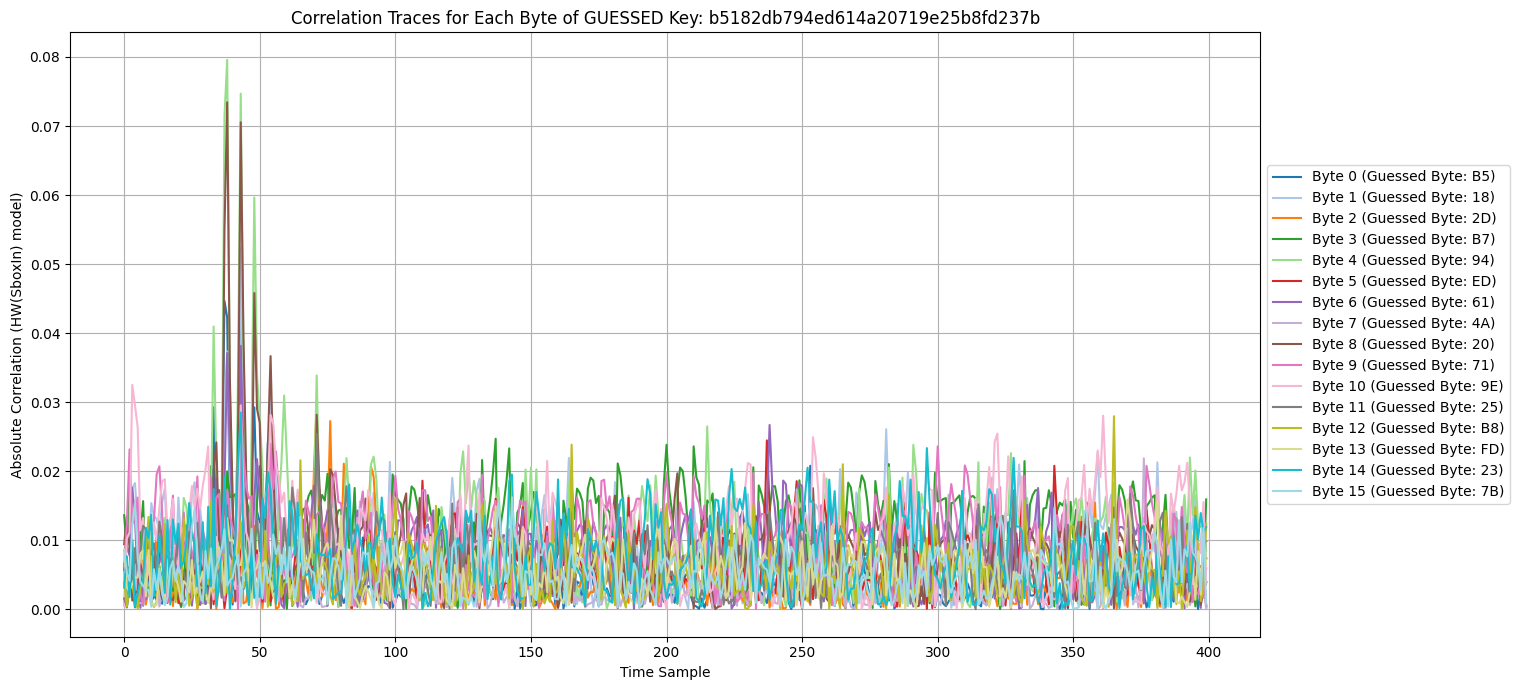


--- Max Absolute Correlation (HW(SboxIn)) for each GUESSED Key Byte ---
Byte  0 (Guessed Byte Value: B5): Max Abs Corr at Sample  43 (Value: 0.0509)
Byte  1 (Guessed Byte Value: 18): Max Abs Corr at Sample  43 (Value: 0.0524)
Byte  2 (Guessed Byte Value: 2D): Max Abs Corr at Sample  71 (Value: 0.0298)
Byte  3 (Guessed Byte Value: B7): Max Abs Corr at Sample 137 (Value: 0.0247)
Byte  4 (Guessed Byte Value: 94): Max Abs Corr at Sample  38 (Value: 0.0796)
Byte  5 (Guessed Byte Value: ED): Max Abs Corr at Sample 237 (Value: 0.0245)
Byte  6 (Guessed Byte Value: 61): Max Abs Corr at Sample  43 (Value: 0.0382)
Byte  7 (Guessed Byte Value: 4A): Max Abs Corr at Sample 376 (Value: 0.0219)
Byte  8 (Guessed Byte Value: 20): Max Abs Corr at Sample  38 (Value: 0.0734)
Byte  9 (Guessed Byte Value: 71): Max Abs Corr at Sample  43 (Value: 0.0284)
Byte 10 (Guessed Byte Value: 9E): Max Abs Corr at Sample   3 (Value: 0.0325)
Byte 11 (Guessed Byte Value: 25): Max Abs Corr at Sample  71 (Value: 0.0254)
Byt

In [28]:
plot_correlation_traces_for_key("b5182db794ed614a20719e25b8fd237b")

Plotting full correlation traces for each byte of the GUESSED key: D60C0F68F220C17E5744C0B0AE05841F
Using Leakage Model: HW(SboxIn)



<ipython-input-24-c4686029205e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20').resampled(16) # Get a colormap with 16 distinct colors


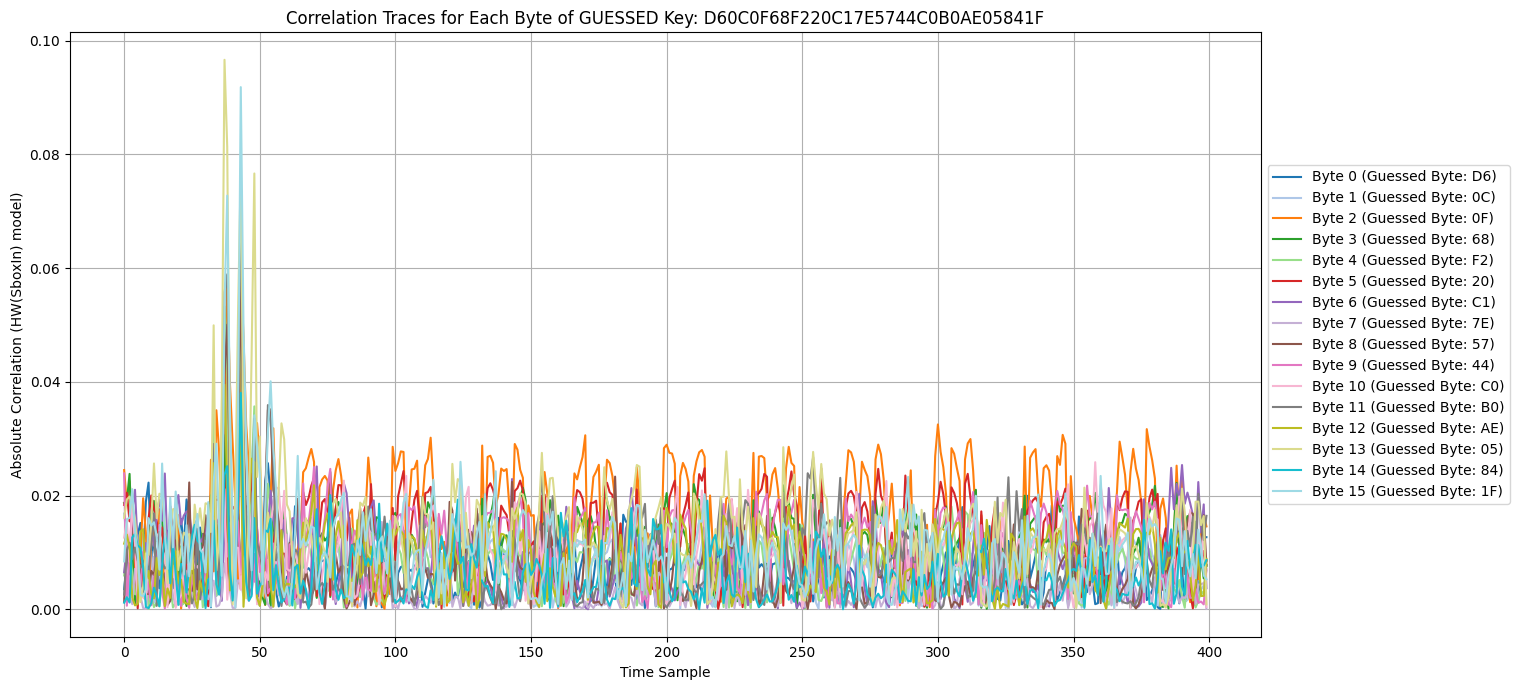


--- Max Absolute Correlation (HW(SboxIn)) for each GUESSED Key Byte ---
Byte  0 (Guessed Byte Value: D6): Max Abs Corr at Sample  43 (Value: 0.0440)
Byte  1 (Guessed Byte Value: 0C): Max Abs Corr at Sample  37 (Value: 0.0415)
Byte  2 (Guessed Byte Value: 0F): Max Abs Corr at Sample  43 (Value: 0.0606)
Byte  3 (Guessed Byte Value: 68): Max Abs Corr at Sample  37 (Value: 0.0306)
Byte  4 (Guessed Byte Value: F2): Max Abs Corr at Sample  37 (Value: 0.0533)
Byte  5 (Guessed Byte Value: 20): Max Abs Corr at Sample 214 (Value: 0.0248)
Byte  6 (Guessed Byte Value: C1): Max Abs Corr at Sample  43 (Value: 0.0341)
Byte  7 (Guessed Byte Value: 7E): Max Abs Corr at Sample 371 (Value: 0.0161)
Byte  8 (Guessed Byte Value: 57): Max Abs Corr at Sample  43 (Value: 0.0583)
Byte  9 (Guessed Byte Value: 44): Max Abs Corr at Sample  70 (Value: 0.0250)
Byte 10 (Guessed Byte Value: C0): Max Abs Corr at Sample 358 (Value: 0.0259)
Byte 11 (Guessed Byte Value: B0): Max Abs Corr at Sample  43 (Value: 0.0737)
Byt

In [27]:
plot_correlation_traces_for_key("D60C0F68F220C17E5744C0B0AE05841F")
#I know this was second most likely from another attempt in a notebook not really worth sharing

##Progress and a Focussed CPA Attack
* This actually worked and gives us something workable, as this time the peaks are much sparser.
* And most Importantly, it shows that the maximum point of correlation for both B5 and D6 is the the sample time 43.
* This indicates that the time 43 is likely highly relevant in leaking the first byte. So instead of looking at the max correlation across all 400 time samples above we can do it just for the time sample 43.
$$$$
How does this work?
* This attack is very similar to the other one, but the two key differences is that we focus on only 1 time sample (43) instead of 400, and we also focus on the leakage model of Hamming Weight of the S-Box Input rather than output.
* Initailly I set this to try and bruteforce the top 2 results but that didn't work so next I tried 3, which gives the result we want.

In [30]:
# --- CPA Attack - Focused on Sample 43 ---
# (This cell now finds top 3 guesses and tries combinations if top 1 not correct)

import numpy as np
import itertools
import time
from tqdm.notebook import trange # Added for progress bar within the function if needed
from Crypto.Cipher import AES # Make sure AES is imported

recovered_key_best_single_guess = [0] * 16 # Keep track of the single best guess for comparison
all_focused_corrs = np.zeros((16, 256)) # Store correlation at target_sample_index
top_guesses_per_byte = [] # List to store the top N guesses for each byte

target_sample_index = 43
num_alternatives = 3 # <--- SET THIS TO 3 (or 2, etc.)
max_combinations_to_test = 1000000 # Limit the search space

attack_start_time = time.time()
print(f"Starting FOCUSED CPA attack (Sample {target_sample_index}, finding top {num_alternatives} guesses)...")

# --- Part 1: Calculate Correlations (mostly same as before) ---
# Loop through each of the 16 key bytes
for byte_num in trange(16, desc="Calculating Correlations"):
    focused_corr_coeffs = np.zeros(256) # Store correlation@target_sample_index for each guess

    # Ensure target sample is valid
    if target_sample_index < 0 or target_sample_index >= traces.shape[1]:
        raise ValueError(f"Target sample index {target_sample_index} is out of bounds.")

    # Get power values ONLY at target sample once
    trace_col = traces[:, target_sample_index]
    trace_col_mean = np.mean(trace_col)
    trace_col_std = np.std(trace_col)

    # Loop through all possible values for this key byte (0-255)
    for k_guess in range(256):
        # Initialize hypothetical_leakage array here
        hypothetical_leakage = np.zeros(num_traces)

        # Calculate hypothetical leakage (using S-Box Input HW model)
        for i in range(num_traces):
            plaintext_byte = plaintexts_np[i, byte_num]
            hypothetical_leakage[i] = calculate_leakage_sbox_input_hw(plaintext_byte, k_guess)

        # Calculate Correlation ONLY at the target sample
        leakage_mean = np.mean(hypothetical_leakage)
        leakage_std = np.std(hypothetical_leakage)

        if leakage_std == 0 or trace_col_std == 0:
            focused_corr_coeffs[k_guess] = 0
        else:
            numerator = np.sum((hypothetical_leakage - leakage_mean) * (trace_col - trace_col_mean))
            denominator = (num_traces * leakage_std * trace_col_std)
            if denominator == 0:
                focused_corr_coeffs[k_guess] = 0
            else:
                focused_corr_coeffs[k_guess] = numerator / denominator

    # Store the absolute correlation values
    all_focused_corrs[byte_num, :] = np.abs(focused_corr_coeffs)

    # Find the single best guess (still useful for comparison)
    best_single_guess_for_byte = np.argmax(np.abs(focused_corr_coeffs))
    recovered_key_best_single_guess[byte_num] = best_single_guess_for_byte

    # Find and store top N guesses for this byte
    sorted_indices = np.argsort(np.abs(focused_corr_coeffs))[::-1] # Sort guesses by abs corr
    top_n = sorted_indices[:num_alternatives]
    top_guesses_per_byte.append(top_n.tolist()) # Store as a list

correlation_end_time = time.time()
print(f"\nCorrelation calculation finished in {correlation_end_time - attack_start_time:.2f} seconds.")

# Print the key derived from only the single best guess for each byte
recovered_key_hex_single = bytes(recovered_key_best_single_guess).hex()
print(f"\nKey from Single Best Guess (Focused on Sample {target_sample_index}): {recovered_key_hex_single}")

# --- Part 2: Try Combinations of Top Guesses ---

def try_alternative_keys(all_corrs, plaintexts_np, first_known_ciphertext_bytes, num_alternatives=2, max_combinations=1000000):
    """
    Tries combinations of the top 'num_alternatives' key byte guesses for each byte,
    based on the provided correlation matrix, and verifies against the known ciphertext.

    Args:
        all_corrs (np.ndarray): A (16, 256) array where all_corrs[b, g] is the
                                ABSOLUTE correlation for byte 'b' with key guess 'g'.
                                (Using absolute correlation to rank guesses).
        plaintexts_np (np.ndarray): The (num_traces, 16) array of plaintexts.
        first_known_ciphertext_bytes (bytes): The known ciphertext for the first plaintext.
        num_alternatives (int): The number of top guesses to consider for each byte (e.g., 2 or 3).
        max_combinations (int): The maximum number of key candidates to test.

    Returns:
        bytes: The correct key if found within the limits, otherwise None.
    """
    print(f"\n--- Trying Alternative Keys (Top {num_alternatives} Guesses) ---")
    print(f"Using correlation data shape: {all_corrs.shape}")
    print(f"Max combinations to test: {max_combinations}")

    if all_corrs.shape != (16, 256):
        print("Error: Invalid shape for all_corrs. Expected (16, 256).")
        return None

    top_guesses_per_byte = []
    print("Determining top guesses for each byte based on correlation...")
    for byte_num in range(16):
        # Sort indices (guesses 0-255) based on absolute correlation values (descending)
        sorted_indices = np.argsort(np.abs(all_corrs[byte_num, :]))[::-1]
        # Take the top 'num_alternatives' indices (guesses)
        top_n_guesses = sorted_indices[:num_alternatives]
        top_guesses_per_byte.append(top_n_guesses.tolist()) # Store as list
        # Optional: Print top guesses for debugging
        # print(f"Byte {byte_num:2d}: Top {num_alternatives} guesses = {[f'{g:02X}' for g in top_n_guesses]} (Corrs: {[f'{all_corrs[byte_num, g]:.4f}' for g in top_n_guesses]})")

    print(f"Generating and testing key candidates...")
    start_time = time.time()
    combinations_tried = 0

    first_plaintext = bytes(plaintexts_np[0]) # Get first plaintext once

    # Use itertools.product to generate combinations of top guesses
    key_candidates = itertools.product(*top_guesses_per_byte)

    for key_candidate_tuple in key_candidates: # Use tqdm(key_candidates, total=total_combinations, desc="Trying Keys") if feasible
        key_candidate = bytes(key_candidate_tuple)
        combinations_tried += 1

        # --- Verification Logic ---
        try:
            cipher = AES.new(key_candidate, AES.MODE_ECB)
            encrypted_pt = cipher.encrypt(first_plaintext)

            if encrypted_pt == first_known_ciphertext_bytes:
                end_time = time.time()
                print("\n--- SUCCESS! ---")
                print(f"Found correct key after {combinations_tried} combinations.")
                print(f"Time taken: {end_time - start_time:.2f} seconds.")
                print(f"Correct Key: {key_candidate.hex()}")
                return key_candidate # Return the correct key
        except Exception as e:
             print(f"Error during verification for key {key_candidate.hex()}: {e}")

        # Print progress occasionally and check max_combinations limit
        if combinations_tried % 500000 == 0: # Print less frequently for large searches
             current_time = time.time()
             print(f"  ... tried {combinations_tried} combinations ({current_time - start_time:.1f} s)")
        if combinations_tried >= max_combinations:
             end_time = time.time()
             print(f"\nStopped after trying {max_combinations} combinations.")
             print(f"Time taken: {end_time - start_time:.2f} seconds.")
             print("Correct key not found within the specified limit.")
             return None # Indicate key not found

    # If the loop finishes without finding the key
    end_time = time.time()
    print(f"\nTried all {combinations_tried} combinations of top {num_alternatives} picks, but none matched.")
    print(f"Time taken: {end_time - start_time:.2f} seconds.")
    return None

try:
    # Load the first known ciphertext bytes
    with open("output_ciphertext.txt", "r") as f:
         first_known_ciphertext_hex = f.readline().strip()
         first_known_ciphertext_bytes_for_func = hex_to_bytes(first_known_ciphertext_hex)

    # --- CHANGE THIS LINE ---
    # Try with the top 3 guesses per byte from the FOCUSED attack
    # Increase max_combinations if needed (3^16 > 43 million)
    num_alt_to_try = 3  # <--- Set to 3 here
    max_comb = 50000000 # <--- Increase if necessary

    print(f"\nRunning alternative key search with Top {num_alt_to_try} guesses...")
    found_key = try_alternative_keys(
        all_focused_corrs,
        plaintexts_np,
        first_known_ciphertext_bytes_for_func,
        num_alternatives=num_alt_to_try,
        max_combinations=max_comb
    )

    if found_key:
        print("\nAlternative key search successful.")
        print("\n--- Final Verification ---")
        first_plaintext = bytes(plaintexts_np[0])
        print(f"First Plaintext:      {first_plaintext.hex()}")
        print(f"Found Key:            {found_key.hex()}")
        cipher = AES.new(found_key, AES.MODE_ECB)
        encrypted_pt = cipher.encrypt(first_plaintext)
        print(f"Ciphertext (using found key): {encrypted_pt.hex()}")
        print(f"Known Ciphertext (from file):   {first_known_ciphertext_bytes_for_func.hex()}")
        if encrypted_pt == first_known_ciphertext_bytes_for_func:
             print("Verification successful.")
        else:
             print("Verification FAILED (unexpected).")
    else:
        print("\nAlternative key search did not find the key within limits.")


except FileNotFoundError:
     print("\nSkipping alternative key search, output_ciphertext.txt not found.")
except NameError as e:
     print(f"\nSkipping alternative key search, a required variable is missing: {e}")
     print("Ensure the 'Focused CPA Attack' cell has run successfully to generate 'all_focused_corrs'.")
except Exception as e:
     print(f"\nAlternative key search failed with error: {e}")


# --- END OF MODIFIED CELL ---

Starting FOCUSED CPA attack (Sample 43, finding top 3 guesses)...


Calculating Correlations:   0%|          | 0/16 [00:00<?, ?it/s]


Correlation calculation finished in 55.41 seconds.

Key from Single Best Guess (Focused on Sample 43): 00010203fb7a060708f60a0b0c4df10f

Running alternative key search with Top 3 guesses...

--- Trying Alternative Keys (Top 3 Guesses) ---
Using correlation data shape: (16, 256)
Max combinations to test: 50000000
Determining top guesses for each byte based on correlation...
Generating and testing key candidates...
  ... tried 500000 combinations (7.7 s)
  ... tried 1000000 combinations (14.7 s)
  ... tried 1500000 combinations (22.1 s)
  ... tried 2000000 combinations (30.9 s)
  ... tried 2500000 combinations (35.7 s)
  ... tried 3000000 combinations (40.6 s)
  ... tried 3500000 combinations (46.5 s)
  ... tried 4000000 combinations (51.2 s)
  ... tried 4500000 combinations (57.2 s)
  ... tried 5000000 combinations (61.9 s)
  ... tried 5500000 combinations (66.7 s)
  ... tried 6000000 combinations (72.7 s)
  ... tried 6500000 combinations (78.6 s)
  ... tried 7000000 combinations (84.6

It worked yay :)

What a silly key